#### 数据

In [29]:
%matplotlib inline
import torch 
from torch import nn 
from d2l import torch as d2l

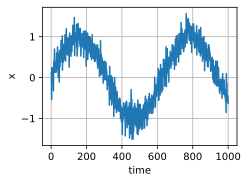

In [30]:
T = 1000
time=torch.arange(1,T+1,dtype=torch.float32)
x=torch.sin(0.01*time) + torch.normal(0,0.2,(T,))
d2l.plot(time,[x],'time','x')

***
***将这个序列转化成特征-标签(feature-label)对***

In [31]:
tau = 4
features = torch.zeros((T-tau,tau))

for i in range(tau):
    features[:,i] = x[i:T-tau+i]
labels=x[tau:].reshape((-1,1))
features.shape,labels.shape

(torch.Size([996, 4]), torch.Size([996, 1]))

In [32]:
batch_size,n_train = 16,600
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),
                            batch_size,is_train=True)
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

#多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4,10),
                       nn.ReLU(),
                       nn.Linear(10,1))
    net.apply(init_weights)
    return net

#平方损失
loss=nn.MSELoss(reduction='none')

In [33]:
def train(net,train_iter,loss,epochs,lr):
    trainer=torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1},'
             f'loss: {d2l.evaluate_loss(net,train_iter,loss):f}')

In [34]:
net=get_net()
train(net,train_iter,loss,5,0.01)

epoch 1,loss: 0.061936
epoch 2,loss: 0.056857
epoch 3,loss: 0.057476
epoch 4,loss: 0.054009
epoch 5,loss: 0.053635


#### 预测

torch.Size([996, 1])


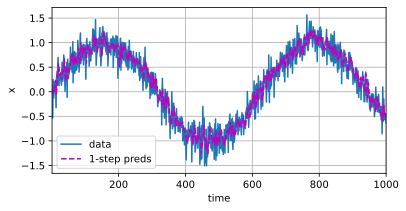

In [35]:
onestep_preds=net(features)
print(onestep_preds.shape)
d2l.plot([time,time[tau:]],
        [x.detach(),onestep_preds.detach()],'time',
        'x',legend=['data','1-step preds'],xlim=[1,1000],
        figsize=((6,3)))

In [36]:
#k步预测
multistep_preds=torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]
for i in range(n_train+tau,T):
    multistep_preds[i] = net(
        multistep_preds[i-tau:i].reshape((1,-1)))

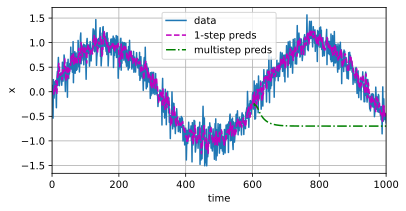

In [37]:
#误差累积
d2l.plot([time,time[tau:],time[n_train+tau:]],
        [x.detach(),onestep_preds.detach(),
        multistep_preds[n_train+tau:].detach()],
        'time','x',
        legend=['data','1-step preds','multistep preds'],
        xlim=[0,1000],figsize=((6,3)))

In [38]:
#k=1,4,16,64
max_steps = 64
features=torch.zeros((T-tau-max_steps+1,tau+max_steps))
#列i（i<tau)是来自x的观测，
for i in range(tau):
    features[:,i] = x[i:i+T-tau-max_steps+1]
#列i(i>=tau)是来自(i-tau+1)步的观测
for i in range(tau,tau+max_steps):
    features[:,i] = net(features[:,i-tau:i]).reshape(-1)

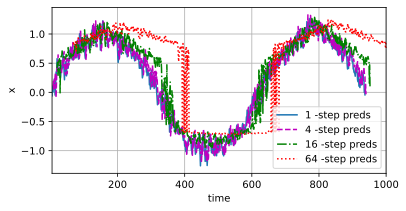

In [39]:
#plot
steps=(1,4,16,64)
d2l.plot([time[tau+i-1:T-max_steps+i] for i in steps],
        [features[:,tau+i-1].detach() for i in steps],
        'time','x',xlim=[5,1000],legend=[f'{i} -step preds' for i in steps],
        figsize=((6,3)))